In [3]:
import sys
import os
import cobra
import libsbml
import pandas as pd
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
from cobra import Reaction


#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src")

import model_initialize as model_init
import model_manipulation  as mm


Checklist:
- add wild type script to this script //
- Change names to reflect WT and trans //
- Incorporate graphs for both WT and trans//

- Check WT FVA @ 1000 PPFD to check CO2 intake and base CO2 script from there.



In [4]:
#init


#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")

wt_model.solver='gurobi'
trans_model.solver = 'gurobi'

inf = 1e6

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-09


In [5]:
#This codeblock is to define some of the functions used for modelling


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'gurobi'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Define linear relationship between PPFD and Cellular maintainance costs
#This formula comes from Topfer et al (2020) where she defined NGAM in a linear relationship with incident light


def generate_constraint(model,reaction, name, lb, ub):
    reaction_fex = model.reactions.get_by_id(name).flux_expression
    constraint = model.problem.Constraint(reaction_fex, lb=lb, ub=ub)
    constraint.name = name + '_constraint'
    model.add_cons_vars

def compute_ngam_atp(ppfd):
    v_atp = 0.0049*ppfd + 2.7851
    return v_atp


#This function is used to set the inputs to the model used. 
def define_model_medium(model, co2, o2, ppfd, 
                        medium_dir='./misc/photo_medium.csv', no3=inf, h2o=inf, h=inf, 
                        nh4=inf, pi=inf):
    model_photo_media = mm.read_medium_csv(medium_dir, model)
    model_photo_media['EX_no3(e)'] = no3
    model_photo_media['EX_h2o(e)'] = h2o
    model_photo_media['EX_h(e)'] = h
    model_photo_media['EX_nh4(e)'] = nh4
    model_photo_media['EX_co2(e)'] = co2
    model_photo_media['EX_o2(e)'] = o2
    model_photo_media['EX_photonVis(e)'] = ppfd
    model_photo_media['EX_pi(e)'] = pi
    #Set set model medium as model
#     print('Added model medium')
    return model_photo_media

    
def turn_off_cofac_cycles(model, inact_dir='./misc/leaf_inactivated.tsv'):
    file = csv.reader(open(inact_dir), delimiter='\t')
    leaf_inactive_rxns = list()
    for rows in file:
        row_m = str()
        row_bs = str()
        for rxns in rows:
            row_m += str(rxns) + "_M"
            row_bs += str(rxns) + "_BS"
        leaf_inactive_rxns.append(row_m)
        leaf_inactive_rxns.append(row_bs)
        
    for rxns in model.reactions:
        if rxns.id in leaf_inactive_rxns:
            rxns.bounds = (0,0)
#     print('Successfully turned off cofactor-cycling reactions')

    
# #Add constraints to model
#This code block contains constraints that would simulate the assimilation rates of bs and m cells in a two-cell system (such as those seen near the midvein region of rice leaves)
# #BS photon flux must be the same/less than M flux (Adapted from B&B, 2019)
# photon_import = model.reactions.get_by_id("EX_photonVis(e)")
def add_tissue_constraints(model):
    #For input fluxes for light, we will set the flux ratio to 10:1 to reflect the anatomical proportions of our model ()
    
    BS_photon_import = model.reactions.PRISM_white_LED_BS
    M_photon_import = model.reactions.PRISM_white_LED_M

    #Set photon flux ratio to 10:1
    photon_flux = mm.set_fix_flux_ratio({M_photon_import.id:10, BS_photon_import.id:1},model)
    model.add_cons_vars(photon_flux)

    
    #UPDATE: Change CO2 intake to the M Cell instead rather than set a ratio, which is a better assumption overall. Assume na lang that external gasses are assimilated
    #Via the M cell.
    #From Morrison et al 2005 -- Lateral diffusion of Gases is unlikely to support photosynthesis due to the
    #assimilation of diffused CO2 in tissues prior to BS//
    model.reactions.CO2tex_BS.bounds = (0,0)
    model.reactions.O2tex_BS.bounds = (0,0)
    
    #UPDATE: This assumption does not hold considering that recent transcriptomic analysis confirms that 
    #the bundle sheath is involved in the assimilation of inorganic nutrients, including nitrogen (nitrates/ammonia), and 
    #Sulfates. In turn, this will be implemented by simply setting the exchanges to the M cell to 0. (Hua et al, 2021)
    model.reactions.SO3tex_M.bounds = (0,0)
    model.reactions.SO4tex_M.bounds = (0,0)
    model.reactions.NH4tex_M.bounds = (0,0)
    model.reactions.NO3tex_M.bounds = (0,0)
    
    #Model will also constraint H2O input to BS cell only as it is also assumed that BS tissue in rice is specialized for H2O transport (Hua et al. 2021)
    #There is a demand reaction naman for H2O for the M cell which is not connected to the BS H2Otex
    #Restrict H2O transport to be unidirectional from the BS cell
    model.reactions.H2Otex_M.bounds = (0, 0)
    model.reactions.h2o_pd.bounds = (-inf, 0)
    
    #need to turn off HCO import as the model incorrectly transfers fixed HCO to the BS cell via the common pool compartment
    model.reactions.HCO3tex_M.bounds = (0,0)
    model.reactions.HCO3tex_BS.bounds = (0,0)
    
    #No constraints will be implemented for H+ availability allowing the model to use protons on-demand.
    
    #Turn off other Demand reactions that may serve as sinks for the model except DM_Phloem_BS (Which represents the output of photoassimilate thru the BS cell
    model.reactions.DM_Phloem_M.bounds = (0,0)
    model.reactions.Straw_Biomass_M.bounds = (0,0)
    model.reactions.Straw_Biomass_BS.bounds = (0,0)
    model.reactions.Coleoptile_Biomass_M.bounds = (0,0)
    model.reactions.Coleoptile_Biomass_BS.bounds = (0,0)
    model.reactions.DM_Phloem_BS.bounds = (0, inf)
    

def add_enzyme_constraints(model, 
                           wt_pepc = 0, 
                           wt_mdh = 11.18, 
                           wt_nadp_me = 0.14, 
                           wt_ppdk=0.31,
                          wt_CA=7.5):
    
    
    # #This code block contains constraints specific for enzyme rate constraints
    #This approach is derived from Bogart & Myers (2016) where they constrained the enzyme rate 
    #fluxes in each of the 2-cell segments to a specific upper bound while keeping the lower bound
    #At 0. For reversible reactions the lower bounds are set to the same value
    
    
    #PEPC constraint (Reaction id: PPCc)
    #Need to constrain it to 0 since reaction is only detected in Vascular tissue
    pepc_BS = model.reactions.PPCc_BS
    pepc_M = model.reactions.PPCc_M
    
    pepc_BS.bounds = (0,0)
    pepc_M.bounds = (0,0)

    #PPDK constraints (Reaction id: PPDKs) (note that this is found in the chloroplast?) 
    #Not detected via immunolocalization but enzyme activity is detected

    ppdks_BS = model.reactions.PPDKs_BS
    ppdks_M = model.reactions.PPDKs_M
    ppdkc_BS = model.reactions.PPDKc_BS
    ppdkc_M = model.reactions.PPDKc_M
    wt_ppdks_cons = model.problem.Constraint(ppdks_BS.flux_expression 
                                             + ppdks_M.flux_expression
                                             + ppdkc_BS.flux_expression
                                             + ppdkc_M.flux_expression, 
                                             lb = 0, ub = wt_ppdk)
    wt_ppdks_cons.name = 'wt_ppdks_cons'
    model.add_cons_vars(wt_ppdks_cons)
    #Malate Dehydrogenase 
    #Only mitochondrial in WT Rice M cells
    mdhm_M = model.reactions.MDHm_M


    wt_mdh_cons = model.problem.Constraint(mdhm_M.flux_expression,
                                           lb= 0, ub=wt_mdh)
    wt_mdh_cons.name = "wt_mdh_cons"
    model.add_cons_vars(wt_mdh_cons)

    #NADP-ME (Since no signal is detected in WT, no locational constraints are imposed)
    #Let's see if I can force it to have a small amount of flux 
    nadp_me_M = model.reactions.MDHys_M
    nadp_me_BS = model.reactions.MDHys_BS

    wt_nadpme_cons = model.problem.Constraint(nadp_me_M.flux_expression
                                             + nadp_me_BS.flux_expression,
                                             lb= 0, ub=wt_nadp_me)
    wt_nadpme_cons.name = "wt_nadpme_cons"
    model.add_cons_vars(wt_nadpme_cons)


    #I should add constraints for Carbonic Anhydrase
    #I should constrain it to 0.4 ubar, which would constitute ambient CO2 partial pressure
    #Flux is reversible so constraints are bi-directional
    #This should be revised considering that it allows reversible reactions  and an abnormally high flux thru carbonic anhydrase, which shouldn't be the case

    hco3es_m = model.reactions.HCO3Es_M.flux_expression
    hco3ec_m = model.reactions.HCO3Ec_M.flux_expression
    hco3em_m = model.reactions.HCO3Em_M.flux_expression
    hco3es_bs = model.reactions.HCO3Es_BS.flux_expression
    hco3ec_bs = model.reactions.HCO3Ec_BS.flux_expression
    hco3em_bs = model.reactions.HCO3Em_BS.flux_expression

    ca_cons = model.problem.Constraint(hco3es_m + hco3ec_m + hco3em_m 
                                       + hco3es_bs + hco3ec_bs + hco3em_bs,
                                      lb = -wt_CA, ub = wt_CA)
    ca_cons.name = 'Carbonic_anhydrase_constraint'
    model.add_cons_vars(ca_cons)


    #Rbcl constaints
    #Retrieve flux expressions oof each RBCl reaction
    rbpc_M = model.reactions.RBPCs_M.flux_expression
    rbpc_BS = model.reactions.RBPCs_BS.flux_expression
    rbpo_M = model.reactions.RBPOs_M.flux_expression
    rbpo_BS = model.reactions.RBPOs_BS.flux_expression

    #Constraint such that it is limited to 132 umol m-2 s-1
    rbcl_vcmax_cons = model.problem.Constraint(rbpc_M + rbpc_BS, lb = 0, ub= 132)
    rbcl_vcmax_cons.name='rbcl_vcmax_cons'
    model.add_cons_vars(rbcl_vcmax_cons)
    #Constraints for rbcl flux such that v_c/v_o = 3 or higher.
    rbcl_vcvo = model.problem.Constraint(3*(rbpo_M + rbpo_BS) 
                                         - 1*(rbpc_M + rbpc_BS),
                                         lb=0,ub=1000)
    rbcl_vcvo.name = 'rbcl_vc/vo_ratio'
    model.add_cons_vars(rbcl_vcvo)

    #Turn off the RBPC2s reactions since we already defined the constraints above
    model.reactions.RBPC2s_M.bounds = (0,0)
    model.reactions.RBPC2s_BS.bounds = (0,0)
    
    
    
    #What if I simply constrained that of the M cell one to 3:1?
    #This constraint is pretty good actually. 
    #This allows the system to be set at a specific Vc/Vo rate while still allowing local variation 
    #wherein Rubisco may act in an uncoupled fashion and may have favorable internal vc/vo rates.
# #This code block is to set a constraint such that M-to-BS cell NGAM ratio is 10-to-1 
# #Similar to what Moreno-Villena et al (2022) had done 

#This function takes two arguments: the model and the maximal  ppfd input to the system
def add_ngam_cons(model, ppfd): 
    ngam_atp_m = mm.get_rxn(model, 'ngam_atp_c_M')
    ngam_atp_bs = mm.get_rxn(model, 'ngam_atp_c_BS')
    ngam_atp_m.bounds = (0,inf)
    ngam_atp_bs.bounds = (0,inf)
    ngam_ratio = mm.set_fix_flux_ratio({ngam_atp_m.id:10, ngam_atp_bs.id:1}, model)
    ngam_ratio.name = 'ngam_BS/M_ratio'
    model.add_cons_vars(ngam_ratio)

    #Retrieve NGAM reactions
    ngam_nadphox_c_M = mm.get_rxn(model, 'ngam_nadphox_c_M')
    ngam_nadphox_s_M = mm.get_rxn(model, 'ngam_nadphox_s_M')
    ngam_nadphox_m_M = mm.get_rxn(model, 'ngam_nadphox_m_M')
    ngam_nadphox_c_BS = mm.get_rxn(model, 'ngam_nadphox_c_BS')
    ngam_nadphox_s_BS = mm.get_rxn(model, 'ngam_nadphox_s_BS')
    ngam_nadphox_m_BS = mm.get_rxn(model, 'ngam_nadphox_m_BS')


    #Set Fixed fluxes
    nadphox_c_s_M = mm.set_fix_flux_ratio({ngam_nadphox_c_M.id:1, ngam_nadphox_s_M.id:1},model)
    nadphox_c_s_M.name = "nadphox_cs_ratio_M"
    nadphox_s_m_M = mm.set_fix_flux_ratio({ngam_nadphox_s_M.id:1, ngam_nadphox_m_M.id:1}, model)
    nadphox_s_m_M.name = "nadphox_sm_ratio_M"

    nadphox_c_s_BS = mm.set_fix_flux_ratio({ngam_nadphox_c_BS.id:1, ngam_nadphox_s_BS.id:1},model)
    nadphox_c_s_BS.name = "nadphox_cs_ratio_BS"
    nadphox_s_m_BS = mm.set_fix_flux_ratio({ngam_nadphox_s_BS.id:1, ngam_nadphox_m_BS.id:1}, model)
    nadphox_s_m_BS.name = "nadphox_sm_ratio_BS"

    #Add constraints
    model.add_cons_vars(nadphox_c_s_M)
    model.add_cons_vars(nadphox_s_m_M)
    model.add_cons_vars(nadphox_c_s_BS)
    model.add_cons_vars(nadphox_s_m_BS)

    #Retrieve flux expressionns
    fex_nadphox_c_M =  mm.get_flux_exp(model, ngam_nadphox_c_M)
    fex_nadphox_s_M = mm.get_flux_exp(model, ngam_nadphox_s_M)
    fex_nadphox_m_M = mm.get_flux_exp(model, ngam_nadphox_m_M)

    fex_nadphox_c_BS =  mm.get_flux_exp(model, ngam_nadphox_c_BS)
    fex_nadphox_s_BS =  mm.get_flux_exp(model, ngam_nadphox_s_BS)
    fex_nadphox_m_BS =  mm.get_flux_exp(model, ngam_nadphox_m_BS)

    fex_atp_c_M = mm.get_flux_exp(model, ngam_atp_m)
    fex_atp_c_BS =  mm.get_flux_exp(model, ngam_atp_bs)

    #Set the constraint between ATP:NADPH NGAM to 3:1
    nadphox_atpase = model.problem.Constraint(3*(fex_nadphox_c_M + fex_nadphox_s_M + fex_nadphox_m_M
                                                       + fex_nadphox_c_BS + fex_nadphox_s_BS + fex_nadphox_m_BS) 
                                         - 1*(fex_atp_c_M + fex_atp_c_BS),
                                         lb=0,ub=0)
    nadphox_atpase.name = "nadphox_atpase_ratio"
    model.add_cons_vars(nadphox_atpase)
    #Compute NGAM value and add constraint as a lower bound/upper bound to model
    ngam_value = compute_ngam_atp(ppfd)
    ngam_cons = model.problem.Constraint(fex_atp_c_M + 
                                        fex_atp_c_BS, lb=ngam_value, ub=ngam_value)
    ngam_cons.name = 'NGAM_ATP_constraint'
    model.add_cons_vars(ngam_cons)
    
#This code  block gives a snapshot of the relevant fluxes on each of the cell types based on the saved sample_fluxes values above

def print_summary(model, sample_fluxes_df):
    print('rbcl M cell: ', sample_fluxes['RBPCs_M'], 'rbcl BS cell: ',sample_fluxes['RBPCs_BS'])
    print('rbcl M cell (photorespiration)', sample_fluxes['RBPOs_M'], 'rbcl BS cell (PR)', sample_fluxes['RBPOs_BS'])
    print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])
    print('RBPC2s_M', sample_fluxes['RBPC2s_M'], 'RBPC2s_BS', sample_fluxes['RBPC2s_BS'])
    print('PEPC M', sample_fluxes['PPCc_M'], 'PEPC BS', sample_fluxes['PPCc_BS'])
    print('Carbonic Anhydrase (Cytosolic) M', sample_fluxes['HCO3Ec_M'], 'Carbonic Anhydrase (Cytosolic) BS', sample_fluxes['HCO3Ec_BS'])
    print('NADP-ME M', sample_fluxes['MDHys_M'], 'NADP-ME BS', sample_fluxes['MDHys_BS'])
    print('Biomass M: ', sample_fluxes['Straw_Biomass_M'], 'Biomass BS', sample_fluxes['Straw_Biomass_BS'])
    print('Phloem M: ', sample_fluxes['DM_Phloem_M'], 'Phloem BS', sample_fluxes['DM_Phloem_BS'])
    print('co2 consumption M', sample_fluxes['CO2tex_M'], 'co2 consumption BS', sample_fluxes['CO2tex_BS'])
    print('o2 consumption M', sample_fluxes['O2tex_M'], 'o2 consumption BS', sample_fluxes['O2tex_BS'])
    print('Photosystem II M', sample_fluxes['PSIINC_M'], 'PSII BS', sample_fluxes['PSIINC_BS'])
    print('PSI M', sample_fluxes['PSIMR_M'], 'PSI BS', sample_fluxes['PSIMR_BS'])
    print('PPFD M: ', sample_fluxes['PRISM_white_LED_M'], 'PPFD BS: ', sample_fluxes['PRISM_white_LED_BS'])
    print('ATP synthesis (stromal) M', sample_fluxes['ATPSs_M'], 'ATP synthase (mit) M', sample_fluxes['ATPSm_M'])
    pd_rxn = [x for x in model.reactions if "pd" in x.id and "h2o" not in x.id]
    pd_abs_flux = 0
    for pds in pd_rxn:
        pd_abs_flux += abs(sample_fluxes[pds.id])
    
    print('pd_abs_flux: ', pd_abs_flux)
    
#initialize list of transgenic reactions to add  to model

def add_trans_reactions(model):
    '''
    This function is used to add a number of new tissue-specific reactions that were not present in the
    original model to facilitate modelling of the transgenic C4 rice
    '''
    trans_list = list()
    #Transgenic PEPC copy
    #PEPC = Chloroplastic in M & V (rxn id: PPCc)
    trans_ppcs = Reaction('trans_PPCs_M')
    trans_ppcs.name = "Phosphoenolpyruvate carboxylase, plastidic (Transgenic)"
    
    pep_s0 = model.metabolites.pep_s0
    hco3_s0 = model.metabolites.hco3_s0
    oaa_s0 = model.metabolites.oaa_s0
    pi_s0 = model.metabolites.pi_s0


    #Add metabolites, bounds, and subsystem
    trans_ppcs.add_metabolites({hco3_s0:-1, pep_s0:-1, oaa_s0:1, pi_s0:1})
    trans_ppcs.bounds= model.reactions.PPCc_M.bounds
    trans_ppcs.subsystem = model.reactions.PPCc_M.subsystem

    trans_list.append(trans_ppcs)


    #Transgenic PPDK Copy
    #Since it already exists I'll just copy and readd it
    trans_ppdks_m = Reaction('trans_PPDKs_M')
    trans_ppdks_m.add_metabolites(model.reactions.PPDKs_M.metabolites)
    trans_ppdks_m.bounds = model.reactions.PPDKs_M.bounds
    trans_ppdks_m.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_ppdks_bs = Reaction('trans_PPDKs_BS')
    trans_ppdks_bs.add_metabolites(model.reactions.PPDKs_BS.metabolites)
    trans_ppdks_bs.bounds = model.reactions.PPDKs_BS.bounds
    trans_ppdks_bs.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_list.append(trans_ppdks_m)
    trans_list.append(trans_ppdks_bs)


    #Transgenic NADP-ME
    #NADP-ME = Mitochondrial in M
    trans_nadp_me = Reaction('trans_MDHym_M')

    #retrieve reactants
    mal_m0 = model.metabolites.get_by_id('mal-L_m0')
    nadp_m0 = model.metabolites.nadp_m0
    h_m0 = model.metabolites.h_m0
    nadph_m0 = model.metabolites.nadph_m0
    oaa_m0 = model.metabolites.oaa_m0

    #Add to rxn
    trans_nadp_me.add_metabolites({mal_m0:-1, nadp_m0:-1, h_m0:1, nadph_m0:1, oaa_m0:1})
    #Add bounds
    trans_nadp_me.bounds=(-inf, inf)

    trans_list.append(trans_nadp_me)


    #Malate Dehydrogenase, mitochondrial (M cell)
    trans_MDHm_M = Reaction('trans_MDHm_M')
    trans_MDHm_M.name = 'Malate Dehydrogenase, Mitochondrial'
    trans_MDHm_M.add_metabolites(model.reactions.MDHm_M.metabolites)
    trans_MDHm_M.subsystem = model.reactions.MDHm_M.subsystem

    trans_list.append(trans_MDHm_M)

    #Malate dehydrogenase, plastidic (M cell)
    trans_MDHs_M = Reaction('trans_MDHs_M')
    trans_MDHs_M.name = 'Malate Dehydrogenase, Plastidic'
    trans_MDHs_M.add_metabolites(model.reactions.MDHs_M.metabolites)
    trans_MDHs_M.subsystem = model.reactions.MDHs_M.subsystem

    trans_list.append(trans_MDHs_M)

    #Malate dehydrogenase, plastidic(BS Cell)
    trans_MDHs_BS = Reaction('trans_MDHs_BS')
    trans_MDHs_BS.name = 'Malate Dehydrogenase, Plastidic'
    trans_MDHs_BS.add_metabolites(model.reactions.MDHs_BS.metabolites)
    trans_MDHs_BS.subsystem = model.reactions.MDHs_BS.subsystem

    trans_list.append(trans_MDHs_BS)


    #Trans CA
    #Cytosolic in M
    trans_hco3ec_M = Reaction('trans_hco3ec_M')
    trans_hco3ec_M.name = 'carbonic anhydrase, cytosolic'
    trans_hco3ec_M.add_metabolites(model.reactions.HCO3Ec_M.metabolites)
    trans_hco3ec_M.bounds = model.reactions.HCO3Ec_M.bounds

    trans_hco3ec_M.subsystem = model.reactions.HCO3Ec_M.subsystem
    trans_list.append(trans_hco3ec_M)


    #Bulk add to model
    model.add_reactions(trans_list)
    
    model.repair()
####ADDING TRANS CONSTRAINTS

def add_trans_constraints(model,
                         trans_pepc_rates = 7.01,
                         trans_ppdks_rates = 3.66,
                         trans_mdh_rates = 152.87,
                         trans_nadp_me_rates = 0.60,
                         trans_CA_rates = 8):
    '''
    This function is used to add another layer of constraints to parametize model based on the
    Enzyme reaction rates assayed from Ermakova et al (2021) where the locations are based on the 
    each of the transgenic enzyme's tissue-specific localizations. 
    '''
    
    #PEPC constraint
    wt_PPCc_M = mm.get_rxn(model, 'PPCc_M')
    wt_PPCc_BS = mm.get_rxn(model, 'PPCc_BS')
    trans_PPCs_M = mm.get_rxn(model, 'trans_PPCs_M')                           
    trans_PEPC_cons = model.problem.Constraint(trans_PPCs_M.flux_expression
                                            +wt_PPCc_BS.flux_expression 
                                            + wt_PPCc_M.flux_expression, 
                                            lb = 0, ub = trans_pepc_rates)

    model.add_cons_vars(trans_PEPC_cons)

    #PPDK constraint
    trans_PPDKs_M  = mm.get_rxn(model, 'trans_PPDKs_M')
    trans_PPDKs_BS = mm.get_rxn(model, 'trans_PPDKs_BS')
    wt_PPDKs_M = mm.get_rxn(model, 'PPDKs_M')
    wt_PPDKs_BS = mm.get_rxn(model, 'PPDKs_BS')
    
    trans_PPDKs_cons = model.problem.Constraint( 
        trans_PPDKs_BS.flux_expression + trans_PPDKs_M.flux_expression 
        +wt_PPDKs_BS.flux_expression + wt_PPDKs_M.flux_expression, 
                                             lb = 0, ub = trans_ppdks_rates)
    trans_PPDKs_cons.name = 'trans_ppdks_cons'
    model.add_cons_vars(trans_PPDKs_cons)


    #Malate Dehydrogenase Constraints
    trans_MDHm_M = mm.get_rxn(model, 'trans_MDHm_M')
    trans_MDHs_M = mm.get_rxn(model, 'trans_MDHs_M')
    trans_MDHs_BS = mm.get_rxn(model, 'trans_MDHs_BS')
    wt_MDHm_M =  mm.get_rxn(model, 'MDHm_M')
    wt_MDHs_M = mm.get_rxn(model, 'MDHs_M')
    wt_MDHs_BS = mm.get_rxn(model, 'MDHs_BS')
    
    trans_mdh_cons =  model.problem.Constraint(
       trans_MDHm_M.flux_expression + 
        wt_MDHm_M.flux_expression + 
        trans_MDHs_M.flux_expression + 
        trans_MDHs_BS.flux_expression +
        wt_MDHs_BS.flux_expression +
        wt_MDHs_M.flux_expression, 
        lb= 0, ub=trans_mdh_rates)

    trans_mdh_cons.name = "trans_mdh_cons"
    model.add_cons_vars(trans_mdh_cons)

    #Add NADP-ME constraints
    trans_MDHym_M = mm.get_rxn(model, 'trans_MDHym_M')
    wt_MDHys_M = mm.get_rxn(model, 'MDHys_M')
    wt_MDHys_BS = mm.get_rxn(model, 'MDHys_BS')
    
    trans_nadpme_cons = model.problem.Constraint(
        trans_MDHym_M.flux_expression + 
        wt_MDHys_M.flux_expression + 
        wt_MDHys_BS.flux_expression,
        lb= 0, ub=trans_nadp_me_rates)
    
    trans_nadpme_cons.name = "trans_nadpme"
    model.add_cons_vars(trans_nadpme_cons)

    #Add carbonic anhydrase constraints

    trans_hco3ec_M = mm.get_rxn(model, 'trans_hco3ec_M')
    wt_hco3ec_M = mm.get_rxn(model, 'HCO3Ec_M')
    wt_hco3em_M = mm.get_rxn(model, 'HCO3Em_M')
    wt_hco3es_M = mm.get_rxn(model, 'HCO3Es_M')
    wt_hco3ec_BS = mm.get_rxn(model, 'HCO3Ec_BS')
    wt_hco3em_BS = mm.get_rxn(model, 'HCO3Em_BS')
    wt_hco3es_BS = mm.get_rxn(model, 'HCO3Es_BS')
    
    trans_ca_cons = model.problem.Constraint(trans_hco3ec_M.flux_expression + 
                                             wt_hco3es_M.flux_expression + 
                                             wt_hco3ec_M.flux_expression + 
                                             wt_hco3em_M.flux_expression + 
                                             wt_hco3es_BS.flux_expression + 
                                             wt_hco3ec_BS.flux_expression + 
                                             wt_hco3em_BS.flux_expression,
                                      lb = -trans_CA_rates, ub = trans_CA_rates)
    trans_ca_cons.name = 'Trans_CA_cons'
    model.add_cons_vars(trans_ca_cons)
    model.repair()
    



Part C. Generating Flux distributions for varying light levels (From 50 to 1500 ppfd)


In [59]:
def get_line_values(df, rxn_name):
    values = df.loc[[rxn_name]].values.flatten()    
    return values

def get_columns_as_list(df):
    # Get the columns of the dataframe
    values = list()
    columns = df.columns.tolist()
    for cols in columns:
        values.append(int(cols))
    return values

#     # Initialize an empty list to store the column values
#     column_values = []

#     # Iterate over each column
#     for column in columns:
#         # Get the values of the column as a list
#         values = df[column].tolist()

#         # Extend the column values list with the values of the current column
#         column_values.extend(values)

#     # Return the column values as a list
#     return column_values

Analysis of results:

June 28, 2023

Interestingly, the model only uses up to 800 to 1000 ppfd despite the fact that it can take more, suggesting that above this value is the light saturated state, consistent with other modeling results such as with Shameer et al (2019).

In [26]:
#Load results from CSV

ppfd_wt = pd.read_csv('./flux_results/PPFD_benchmark/FBA/WT/PPFD-benchmark-WT-model-Mature-Leaf-20230617-00:35.tsv', sep='\t', index_col=0)
ppfd_tr = pd.read_csv('./flux_results/PPFD_benchmark/FBA/Trans/PPFD-benchmark-trans-model-Mature-Leaf-20230617-00:36.tsv', sep='\t', index_col=0)


,25,75,125,175,225,275,325,375,425,475,...,1075,1125,1175,1225,1275,1325,1375,1425,1475,1525
EX_photonVis(e),-25.0,-75.0,-125.0,-175.0,-225.0,-275.0,-325.0,-375.0,-425.0,-475.0,...,-804.239882,-805.448715,-807.403466,-809.44183,-811.483045,-813.53281,-815.574025,-817.61524,-819.656455,-821.69767


In [60]:
phloem_trans_out = get_line_values(ppfd_wt, 'DM_Phloem_BS')
phloem_wt_out = get_line_values(ppfd_tr, 'DM_Phloem_BS')
ppfd_e = get_columns_as_list(ppfd_tr)


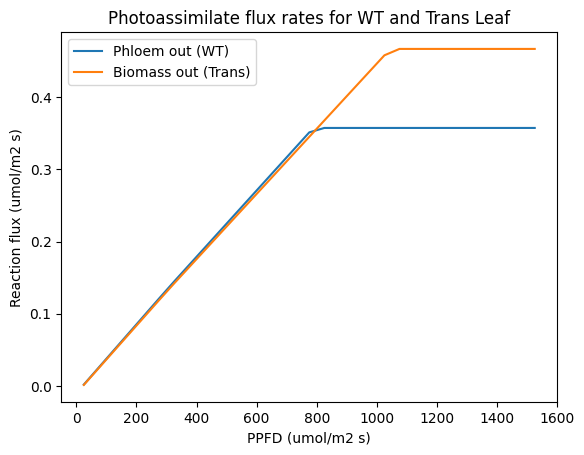

In [62]:
#Let's graph the initial results first

#plot PPFD vs CO2 uptake



plt.plot(ppfd_e, phloem_wt_out, label="Phloem out (WT)")
plt.plot(ppfd_e, phloem_trans_out, label="Biomass out (Trans)")
plt.title(label='Photoassimilate flux rates for WT and Trans Leaf')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Reaction flux (umol/m2 s)')

# Generate evenly spaced ticks by 250

plt.legend()
plt.show()



#I think I need to graph previous data regarding this?
#Based on this, it shows that photoassimilation becomes unstable in intermediate lights  as opposed to
#Having a more stable output 

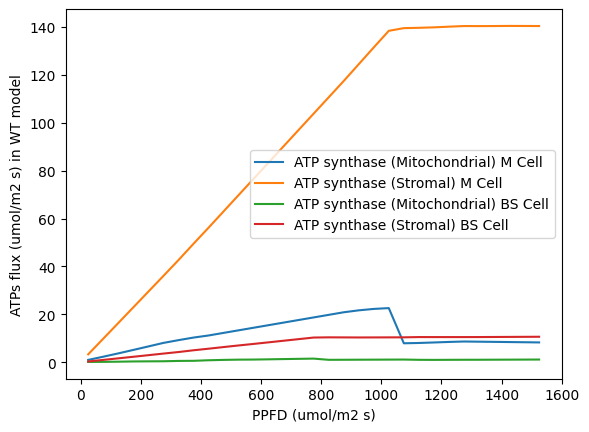

In [65]:
# Plot ATPs_M and ATPSs vs. ppfd
ATPSm_m =  get_line_values(ppfd_wt, 'ATPSm_M')
ATPSs_m =  get_line_values(ppfd_wt, 'ATPSs_M')

ATPSm_bs =  get_line_values(ppfd_tr, 'ATPSm_BS')

ATPSs_bs =  get_line_values(ppfd_tr, 'ATPSs_BS')



plt.plot(ppfd_e, ATPSm_m, label="ATP synthase (Mitochondrial) M Cell")
plt.plot(ppfd_e, ATPSs_m, label="ATP synthase (Stromal) M Cell")
plt.plot(ppfd_e, ATPSm_bs, label="ATP synthase (Mitochondrial) BS Cell")
plt.plot(ppfd_e, ATPSs_bs, label="ATP synthase (Stromal) BS Cell")
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s) in WT model')
plt.legend()
plt.show()


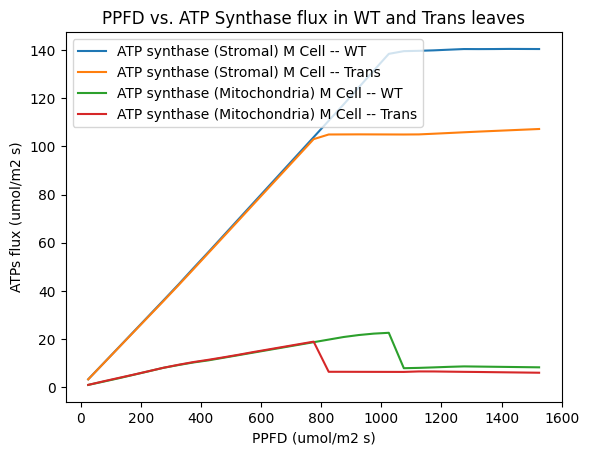

In [66]:
# Plot ATPs_M and ATPSs vs. ppfd in WT and Trans cell
ATPSs_wt =  ppfd_2cell_wt_phloem.loc[['ATPSs_M']].values.flatten()
ATPSs_trans =  ppfd_2cell_trans_phloem.loc[['ATPSs_M']].values.flatten()


ATPSm_wt = ppfd_2cell_wt_phloem.loc[['ATPSm_M']].values.flatten()
ATPSm_trans =  ppfd_2cell_trans_phloem.loc[['ATPSm_M']].values.flatten()


plt.plot(ppfd_e, ATPSs_wt, label="ATP synthase (Stromal) M Cell -- WT")
plt.plot(ppfd_e, ATPSs_trans, label="ATP synthase (Stromal) M Cell -- Trans")

plt.plot(ppfd_e, ATPSm_wt, label="ATP synthase (Mitochondria) M Cell -- WT")
plt.plot(ppfd_e, ATPSm_trans, label="ATP synthase (Mitochondria) M Cell -- Trans")

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s)')
plt.title('PPFD vs. ATP Synthase flux in WT and Trans leaves')
plt.legend()
plt.show()


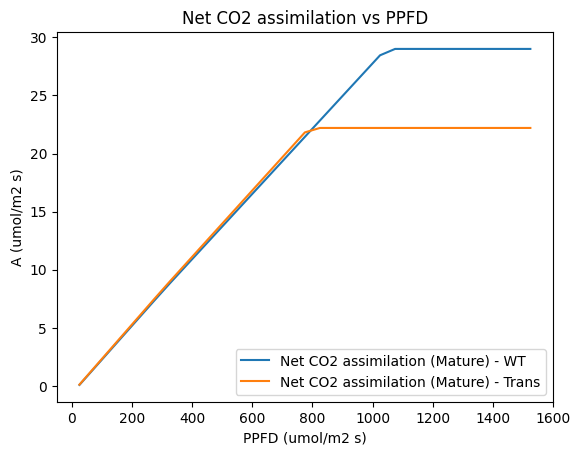

In [67]:
#Show CO2 assimilation comparing growing leaf and mature leaf
co2_wt_mature = ppfd_2cell_wt_phloem.loc[['EX_co2(e)']].values.flatten()
co2_trans_mature = ppfd_2cell_trans_phloem.loc[['EX_co2(e)']].values.flatten()
plt.plot(ppfd_e, co2_wt_mature *-1, label='Net CO2 assimilation (Mature) - WT')
plt.plot(ppfd_e, co2_trans_mature *-1, label='Net CO2 assimilation (Mature) - Trans')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PPFD')
plt.legend()
plt.show()


In [68]:
wt_model.reactions.PSIMR_M

Reaction identifier,PSIMR_M
Name,photosystem I
Memory address,0x7f188ad8d630
Stoichiometry,"2.0 fdxox_u0 + 2.0 h_u0 + 2.0 pccu1p_u0 + 2.0 photonPSI_u0 --> 2.0 fdxrd_u0 + 2.0 pccu2p_u0 2.0 Oxidized ferredoxin + 2.0 H+ + 2.0 Plastocyanin(Cu+) + 2.0 photon (380 to 750 nm, visible spectrum) --> 2.0 Reduced ferredoxin + 2.0 Plastocyanin(Cu2+)"
GPR,LOC_Osp1g00920 and LOC_Osp1g00450 and LOC_Osp1g00550 and LOC_Osp1g00350 and LOC_Osp1g00340 and...
Lower bound,0.0
Upper bound,1000000.0


The following graph shows the ratio between the PSII and PSI systems in WT and TR models. Our reference value from green algae Synechocystis sp. is 0.5 (From https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=2&id=111246) 

Changing the PSI to PSII ratios instead yields us values ranging from 1.58 to 1.72, whgich is fairly consistent with reference values from Ozaki et al (2021). Interestingly, the model predicts a variation of flux ratios with the maximal just before the saturation point before falling to around 0.5 in both cases. Since the TR model reaches saturation point at an earlier point than the WT model the model reaches a lower peak 

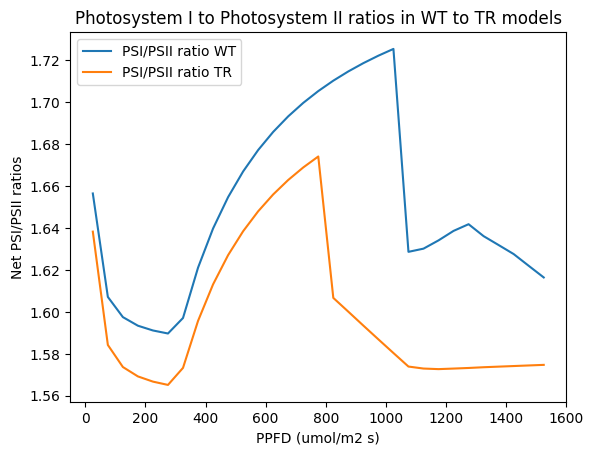

In [82]:
#Show PSII to PSI ratio in both WT and Trans Models

psii_psi_ratio_wt = 1/((get_line_values(ppfd_wt, 'PSIINC_M') + get_line_values(ppfd_wt, 'PSIINC_BS'))/ (get_line_values(ppfd_wt, 'PSIMR_M') + get_line_values(ppfd_wt, 'PSIMR_BS')))

psii_psi_ratio_tr = 1/((get_line_values(ppfd_tr, 'PSIINC_M') + get_line_values(ppfd_tr, 'PSIINC_BS'))/ (get_line_values(ppfd_tr, 'PSIMR_M') + get_line_values(ppfd_tr, 'PSIMR_BS')))

plt.plot(ppfd_e, psii_psi_ratio_wt, label='PSI/PSII ratio WT')
plt.plot(ppfd_e, psii_psi_ratio_tr, label='PSI/PSII ratio TR')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Net PSI/PSII ratios')
plt.title('Photosystem I to Photosystem II ratios in WT to TR models')
plt.legend()
plt.show()

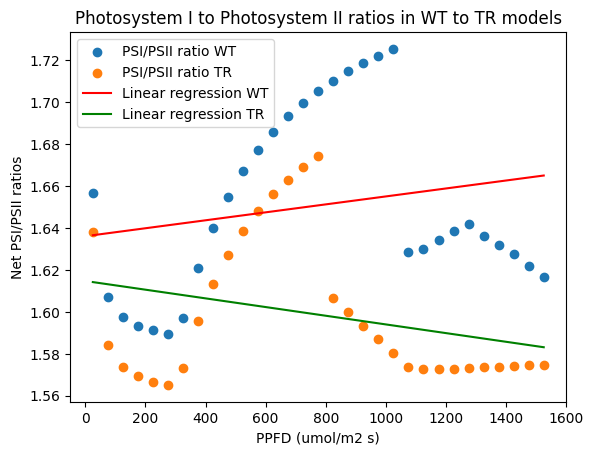

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate PSII to PSI ratio for WT model
psii_psi_ratio_wt = 1 / ((get_line_values(ppfd_wt, 'PSIINC_M') + get_line_values(ppfd_wt, 'PSIINC_BS')) / (get_line_values(ppfd_wt, 'PSIMR_M') + get_line_values(ppfd_wt, 'PSIMR_BS')))

# Calculate PSII to PSI ratio for Trans model
psii_psi_ratio_tr = 1 / ((get_line_values(ppfd_tr, 'PSIINC_M') + get_line_values(ppfd_tr, 'PSIINC_BS')) / (get_line_values(ppfd_tr, 'PSIMR_M') + get_line_values(ppfd_tr, 'PSIMR_BS')))

# Create scatter plot
plt.scatter(ppfd_e, psii_psi_ratio_wt, label='PSI/PSII ratio WT')
plt.scatter(ppfd_e, psii_psi_ratio_tr, label='PSI/PSII ratio TR')

# Add linear regression line for WT model
regression_wt = np.polyfit(ppfd_e, psii_psi_ratio_wt, 1)
plt.plot(ppfd_e, np.polyval(regression_wt, ppfd_e), color='red', label='Linear regression WT')

# Add linear regression line for Trans model
regression_tr = np.polyfit(ppfd_e, psii_psi_ratio_tr, 1)
plt.plot(ppfd_e, np.polyval(regression_tr, ppfd_e), color='green', label='Linear regression TR')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Net PSI/PSII ratios')
plt.title('Photosystem I to Photosystem II ratios in WT to TR models')
plt.legend()
plt.show()

In [ ]:
#The following graph shows a plot of the PSII and PSI 



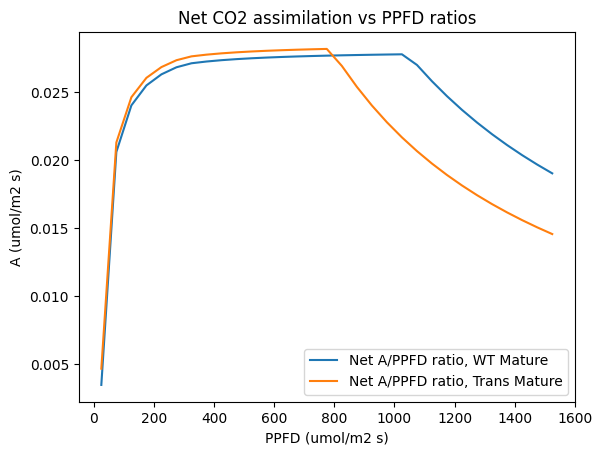

In [76]:
#Show co2 to ppfd ratio comparing growing leaf and mature leaf
#I think it would be better to use flux of PSII instead?




plt.plot(ppfd_e, -1*co2_wt_mature/ppfd_e, label='Net A/PPFD ratio, WT Mature')
plt.plot(ppfd_e, -1*co2_trans_mature/ppfd_e, label='Net A/PPFD ratio, Trans Mature')


plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PPFD ratios')
plt.legend()
plt.show()


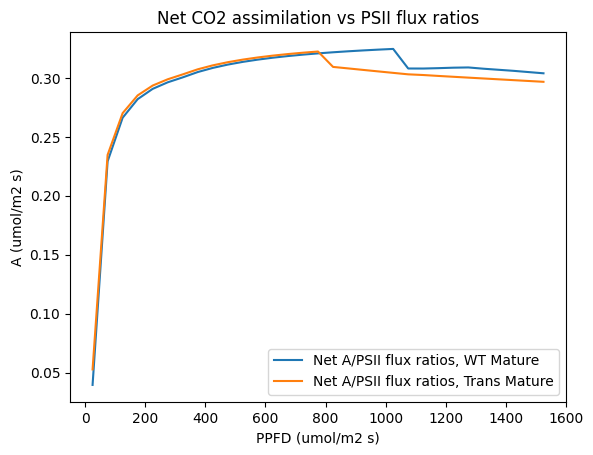

In [77]:
#A vs PSII flux

psii_wt_phl = ppfd_2cell_wt_phloem.loc[['PSIINC_M']].values.flatten() + \
                ppfd_2cell_wt_phloem.loc[['PSIINC_BS']].values.flatten()

psii_trans_phl =  ppfd_2cell_trans_phloem.loc[['PSIINC_M']].values.flatten() + \
                ppfd_2cell_trans_phloem.loc[['PSIINC_BS']].values.flatten()




plt.plot(ppfd_e, -1*co2_wt_mature/psii_wt_phl, label='Net A/PSII flux ratios, WT Mature')
plt.plot(ppfd_e, -1*co2_trans_mature/psii_trans_phl, label='Net A/PSII flux ratios, Trans Mature')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PSII flux ratios')
plt.legend()
plt.show()


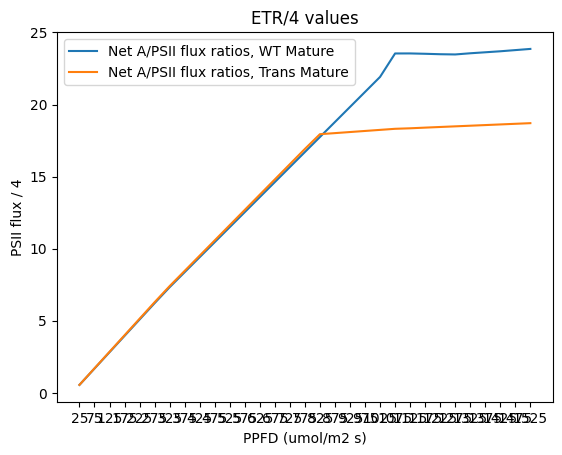

In [28]:
#Plot ETR flux vs PPFD

plt.plot(ppfd_e, psii_wt_phl/4, label='Net A/PSII flux ratios, WT Mature')
plt.plot(ppfd_e, psii_trans_phl/4, label='Net A/PSII flux ratios, Trans Mature')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('PSII flux / 4')
plt.title('ETR/4 values')
plt.legend()
plt.show()

#@ 1500 PPFD, CO2 needs to start at around ETR/4=20 

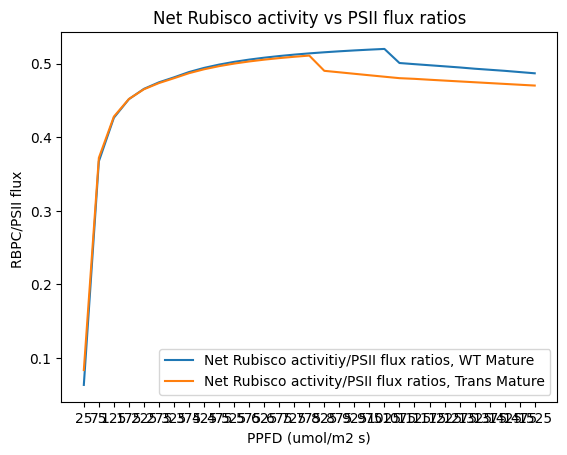

In [51]:
#Rubisco flux vs. psii flux ratios

#A vs PSII flux

psii_wt_phl = ppfd_2cell_wt_phloem.loc[['PSIINC_M']].values.flatten() + \
                ppfd_2cell_wt_phloem.loc[['PSIINC_BS']].values.flatten()

psii_trans_phl =  ppfd_2cell_trans_phloem.loc[['PSIINC_M']].values.flatten() + \
                ppfd_2cell_trans_phloem.loc[['PSIINC_BS']].values.flatten()

rubisco_total_wt = ppfd_2cell_wt_phloem.loc[['RBPCs_M']].values.flatten() + \
            ppfd_2cell_wt_phloem.loc[['RBPOs_M']].values.flatten() + \
            ppfd_2cell_wt_phloem.loc[['RBPCs_BS']].values.flatten() + \
            ppfd_2cell_wt_phloem.loc[['RBPOs_BS']].values.flatten() 

rubisco_total_trans = ppfd_2cell_trans_phloem.loc[['RBPCs_M']].values.flatten()+ \
            ppfd_2cell_trans_phloem.loc[['RBPOs_M']].values.flatten() + \
            ppfd_2cell_trans_phloem.loc[['RBPCs_BS']].values.flatten() + \
            ppfd_2cell_trans_phloem.loc[['RBPOs_BS']].values.flatten() 

rub_psii_ratio_wt = rubisco_total_wt/psii_wt_phl
rub_psii_ratio_trans = rubisco_total_trans/psii_trans_phl

plt.plot(ppfd_e, rub_psii_ratio_wt, label='Net Rubisco activitiy/PSII flux ratios, WT Mature')
plt.plot(ppfd_e, rub_psii_ratio_trans, label='Net Rubisco activity/PSII flux ratios, Trans Mature')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('RBPC/PSII flux ')
plt.title('Net Rubisco activity vs PSII flux ratios')
plt.legend()
plt.show()


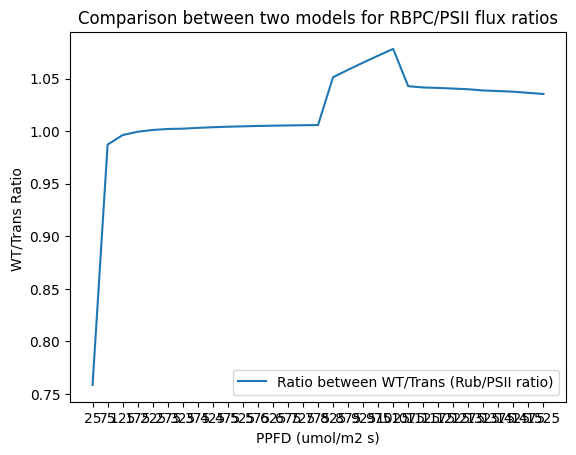

In [53]:
#Plotting the ratios of both WT and trans to see how much they differ


plt.plot(ppfd_e, rub_psii_ratio_wt/rub_psii_ratio_trans, label='Ratio between WT/Trans (Rub/PSII ratio)')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('WT/Trans Ratio ')
plt.title('Comparison between two models for RBPC/PSII flux ratios')
plt.legend()
plt.show()


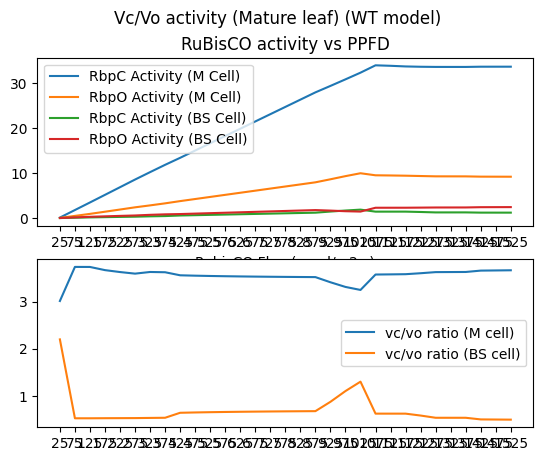

In [33]:
#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_2cell_wt_phloem.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_2cell_wt_phloem.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_2cell_wt_phloem.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_2cell_wt_phloem.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs



fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (Mature leaf) (WT model)')
# fig.set_xlabel('PPFD (umol/m2 s)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_xlabel('RubisCO Flux (umol/m2 s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()


ax2.plot(ppfd_e,  vcvo_m, label='vc/vo ratio (M cell)')
ax2.plot(ppfd_e, vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.legend()



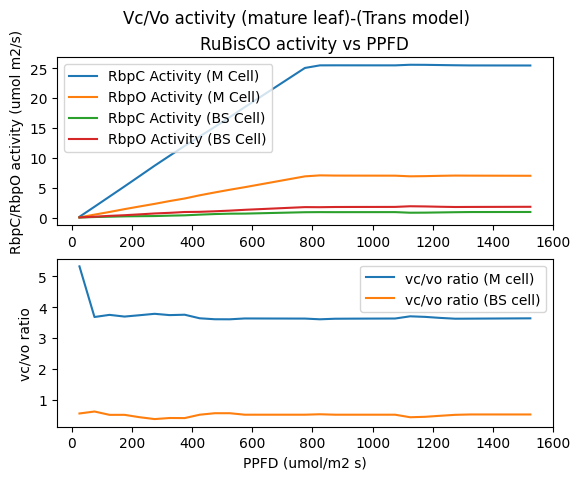

In [39]:
#RBCl activities (Trans model)

#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_2cell_trans_phloem.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_2cell_trans_phloem.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_2cell_trans_phloem.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_2cell_trans_phloem.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs

vcvo_total = (rbpc_m + rbpc_bs)/(rbpo_m + rbpo_bs)


fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (mature leaf)-(Trans model)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_ylabel('RbpC/RbpO activity (umol m2/s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()


ax2.plot(ppfd_e, vcvo_m, label='vc/vo ratio (M cell)')
ax2.plot(ppfd_e,  vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.set_xlabel('PPFD (umol/m2 s)')
ax2.set_ylabel('vc/vo ratio')
ax2.legend()
# ax2.set_title('Vc/Vo ratio comparisons between BS and M cells')


#Top is rubisco fluxes while bottom is vc/vo ratios. Note that the vc/vo ratios at the bottom portion 
#are disrupted due to zero values in a number of 

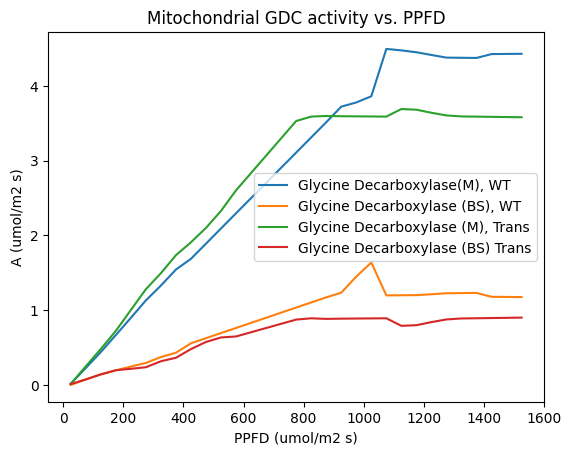

In [20]:
#Glycine Decarboxylase flux in WT and Trans model

GLYDHD_wt_M = ppfd_2cell_wt_phloem.loc[['GLYDHDm_M']].values.flatten()
GLYDHD_wt_BS = ppfd_2cell_wt_phloem.loc[['GLYDHDm_BS']].values.flatten()

GLYDHD_trans_M = ppfd_2cell_trans_phloem.loc[['GLYDHDm_M']].values.flatten()
GLYDHD_trans_BS = ppfd_2cell_trans_phloem.loc[['GLYDHDm_BS']].values.flatten()


plt.plot(ppfd_e, GLYDHD_wt_M, label='Glycine Decarboxylase(M), WT ')
plt.plot(ppfd_e, GLYDHD_wt_BS, label='Glycine Decarboxylase (BS), WT ')
plt.plot(ppfd_e, GLYDHD_trans_M, label='Glycine Decarboxylase (M), Trans')
plt.plot(ppfd_e, GLYDHD_trans_BS, label='Glycine Decarboxylase (BS) Trans')


plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Mitochondrial GDC activity vs. PPFD')
plt.legend()
plt.show()


#Maximal Glycine Decarboxylase in Trans is around 3.5, for WT it is around 4.5



<Axes: >

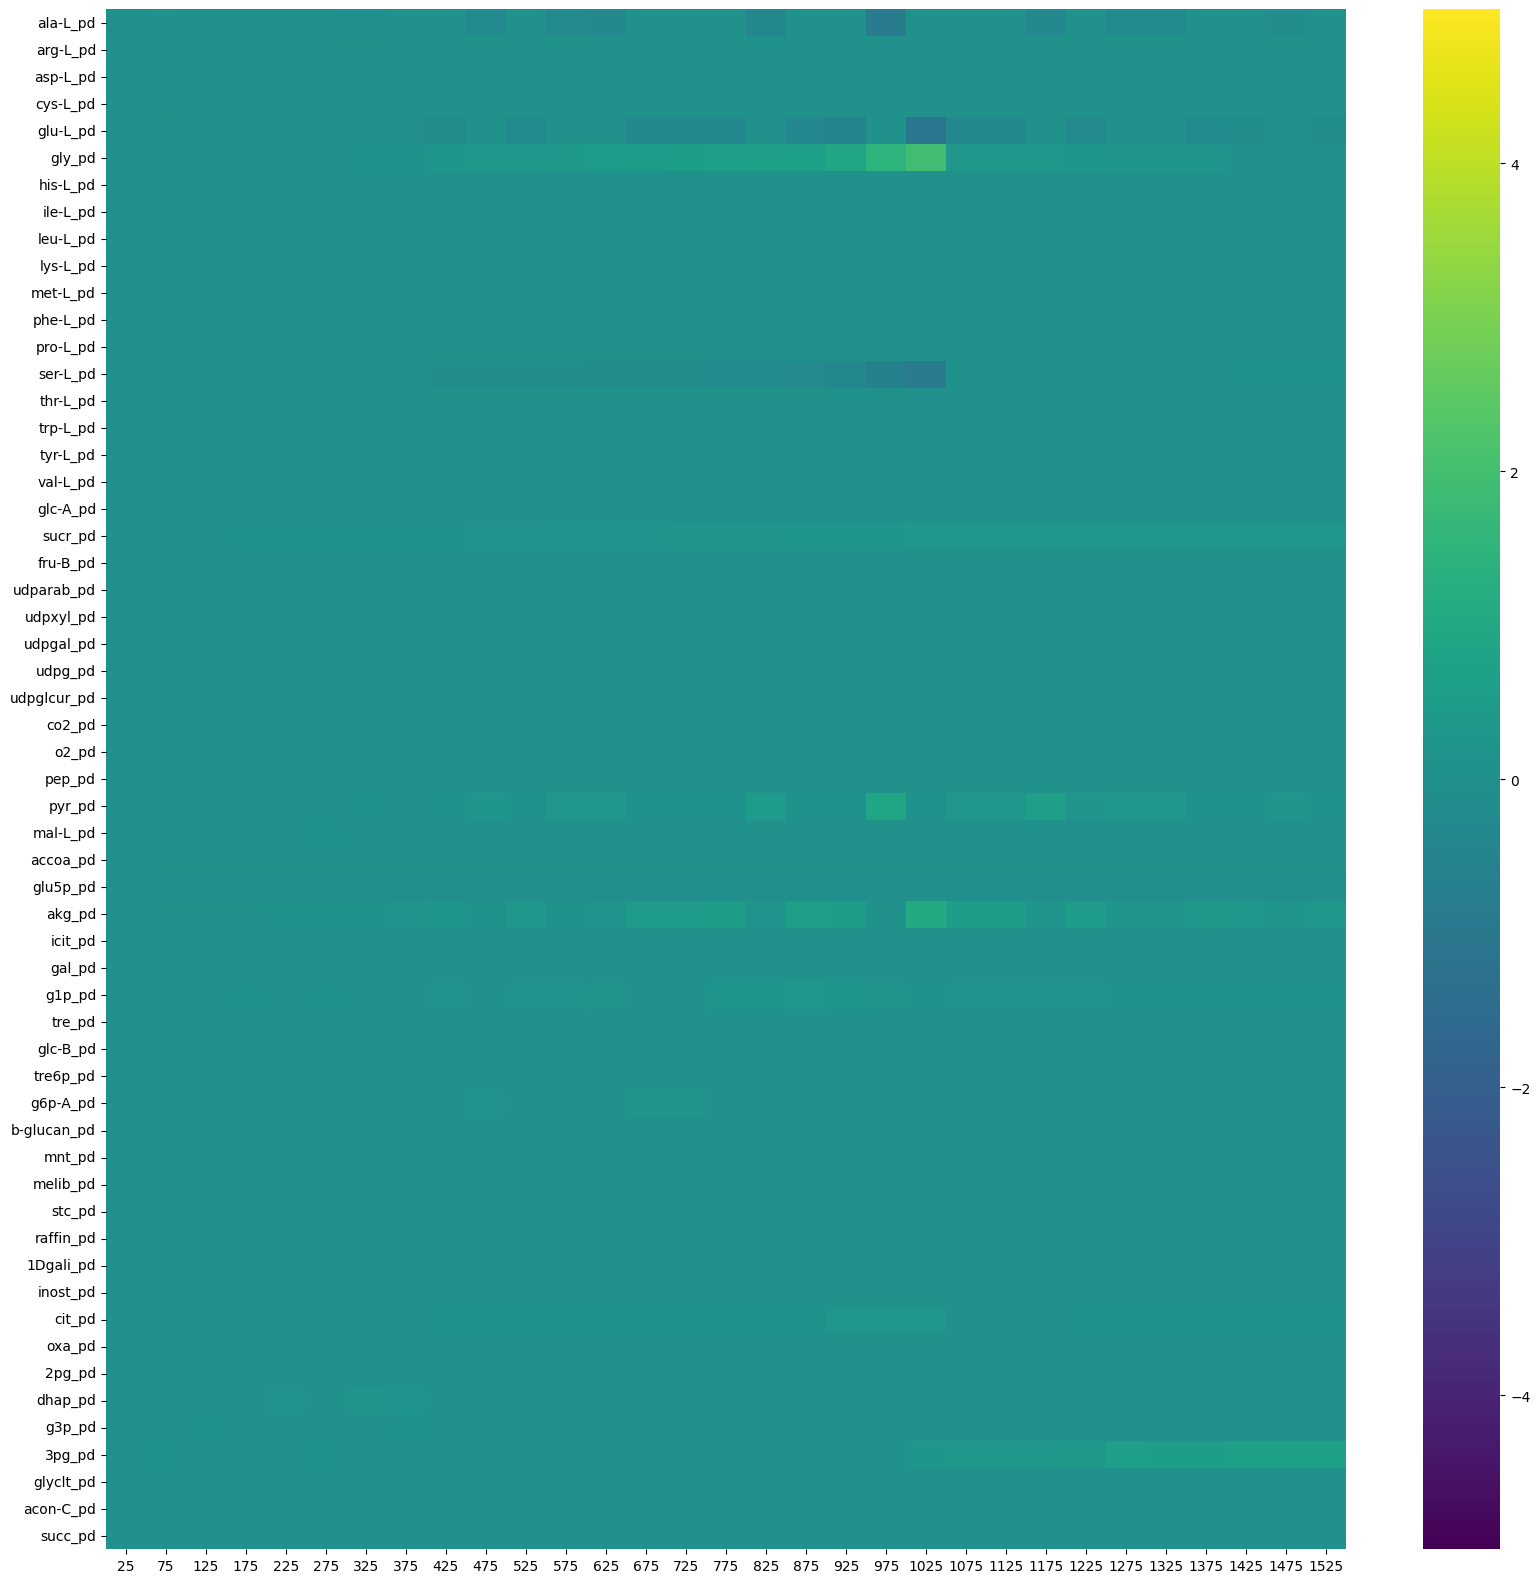

In [41]:
phloem_ppfd = ppfd_2cell_wt_phloem.transpose()

pd_transport_ids = [rxns.id for rxns in wt_model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd = phloem_ppfd[pd_transport_ids].transpose()
pd_phloem_ppfd.loc[~(pd_phloem_ppfd<-inf).all(axis=1)]
pd_phloem_ppfd


plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd, cmap='viridis', vmin=-5, vmax=5)

<Axes: >

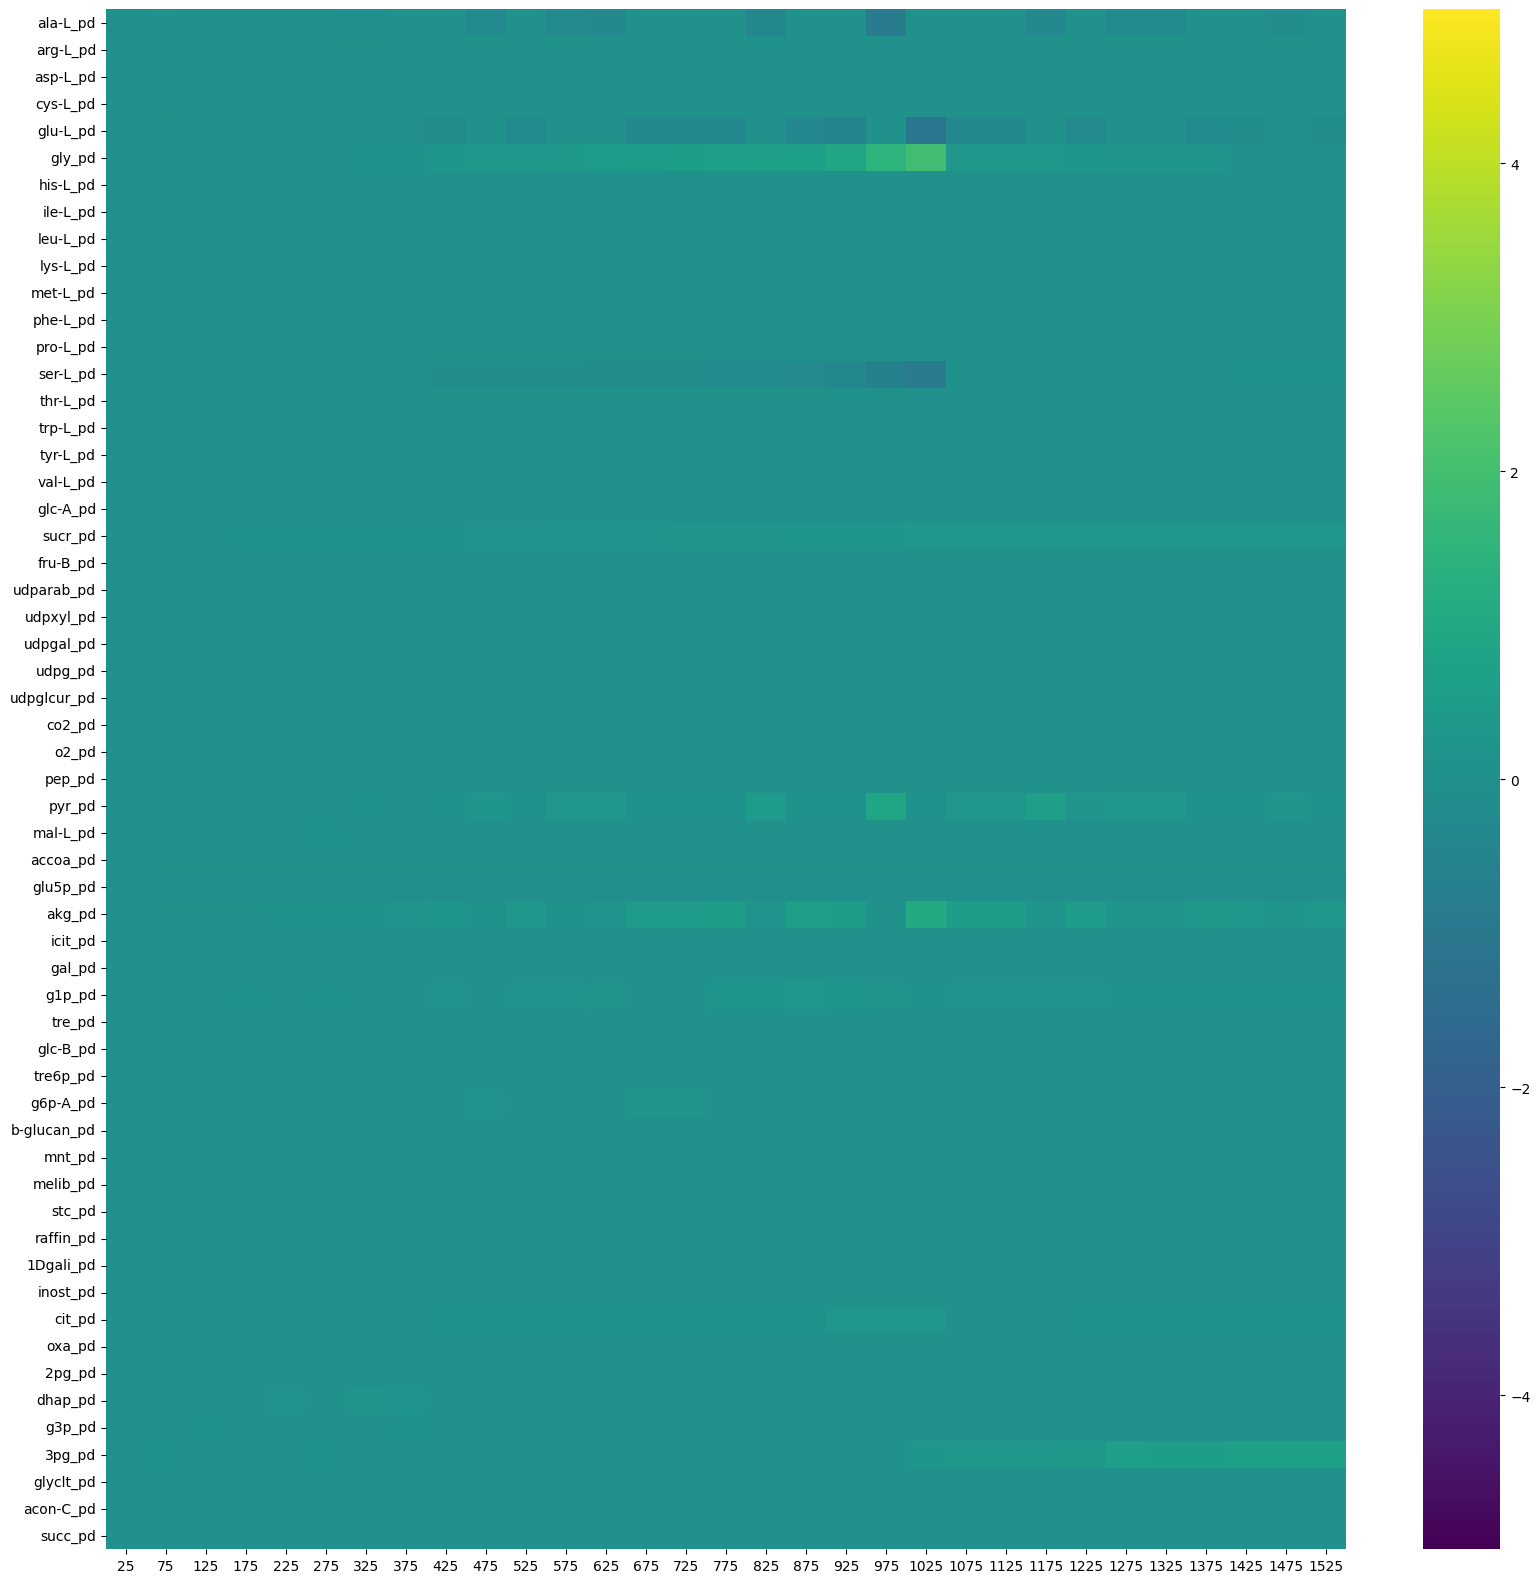

In [50]:
phloem_trans_ppfd = ppfd_2cell_trans_phloem.transpose()

pd_transport_ids = [rxns.id for rxns in trans_model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_trans_ppfd = phloem_ppfd[pd_transport_ids].transpose()
pd_phloem_trans_ppfd.loc[~(pd_phloem_ppfd<-inf).all(axis=1)]
pd_phloem_trans_ppfd


plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd, cmap='viridis', vmin=-5, vmax=5)

<function matplotlib.pyplot.show(close=None, block=None)>

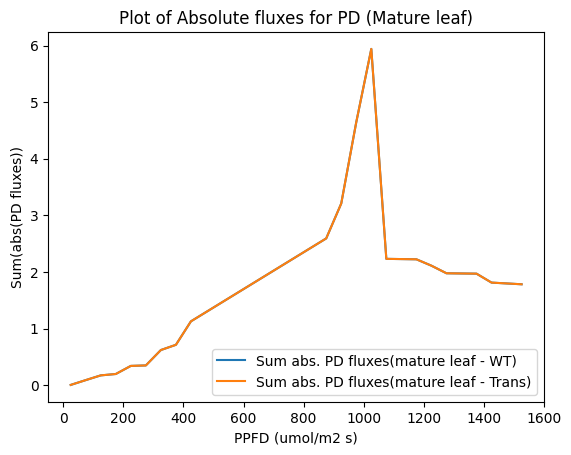

In [51]:
#This code block is to generate a bar graph showing PD sum of fluxes  per ppfd

pd_phloem_abs_flux = pd_phloem_ppfd.abs().sum(axis=0)
pd_phloem_trans_abs_flux = pd_phloem_trans_ppfd.abs().sum(axis=0)


plt.plot(pd_phloem_abs_flux.index, pd_phloem_abs_flux, label='Sum abs. PD fluxes(mature leaf - WT)')
plt.plot(pd_phloem_trans_abs_flux.index, pd_phloem_trans_abs_flux, label='Sum abs. PD fluxes(mature leaf - Trans)')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Sum(abs(PD fluxes))')
plt.title('Plot of Absolute fluxes for PD (Mature leaf)')
plt.legend()
plt.show


In [72]:
def subset_fluxes(flux_df, ids):
    df_index = flux_df.index
    if isinstance(ids, tuple):
        subset = flux_df.loc[df_index.str.contains('|'.join(ids))]
    elif isinstance(ids, str):
        subset = flux_df.loc[df_index.str.contains(ids)]
    subset = subset.loc[~(subset==0).all(axis=1)]
    return subset



PEPC_flux = subset_fluxes(ppfd_2cell_wt_phloem, ('PPCc', 'PPCs'))
PPDK_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'PPDKs')
RBPC_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'RBPC')
RBPO_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'RBPO')
HCO3E_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'HCO3')
MDH_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'MDH')
MDHy_flux = subset_fluxes(MDH_flux, 'MDHy')


MDH_flux

,25,75,125,175,225,275,325,375,425,475,...,1075,1125,1175,1225,1275,1325,1375,1425,1475,1525
MDHc_M,-1.226000,-2.181272,-3.093530,-3.985883e+00,-4.880528,-5.778797,-6.624205e+00,-7.279867,-7.957621,-8.618715,...,-4.039381,-4.019958,-3.994731,-3.822324,-3.624553,-3.622339,-3.620058,-3.590508,-3.586299,-3.582089
MDHx_M,0.014763,0.180249,0.350456,5.352761e-01,0.722388,0.913124,1.130126e+00,1.312653,1.517273,1.705232,...,4.039381,4.019958,3.994731,3.867644,3.724071,3.721857,3.719577,3.690026,3.685817,3.681608
MDHm_M,1.211897,2.012731,2.765829,3.484411e+00,4.202992,4.921573,5.588654e+00,6.076856,6.565057,7.053259,...,0.211879,0.211879,0.211879,0.211879,0.211879,0.211879,0.211879,0.211879,0.211879,0.211879
MDHARyc_M,0.000000,0.000000,0.000000,-2.142797e-11,0.000000,0.000000,4.784617e-12,0.000000,0.000000,0.000000,...,0.000000,0.636906,0.673803,16.940685,0.716214,0.752635,0.788998,0.862635,0.000000,0.940930
MDHys_BS,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.374378e-03,0.001593,0.001812,0.002031,...,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525
MDHs_BS,-0.000121,-0.002141,-0.004161,-6.181424e-03,-0.008202,-0.010222,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MDHc_BS,-0.115953,-0.086432,-0.100789,-1.350526e-01,-0.167024,-0.195371,-2.221090e-01,-0.255008,-0.265815,-0.293283,...,-0.401259,-0.403067,-0.404737,-0.552191,-0.728282,-0.730497,-0.732777,-0.762327,-0.766537,-0.770746
MDHx_BS,0.000000,0.066419,0.128982,1.769321e-01,0.222591,0.264625,2.634822e-01,0.302973,0.320371,0.354429,...,0.637002,0.638810,0.640481,0.742614,0.864507,0.866721,0.869002,0.898552,0.902761,0.906971
MDHm_BS,0.116770,0.034517,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IMDHTs_BS,0.000024,0.000428,0.000831,1.234705e-03,0.001638,0.002042,2.439557e-03,0.002828,0.003217,0.003606,...,0.008032,0.008032,0.008032,0.008032,0.008032,0.008032,0.008032,0.008032,0.008032,0.008032


In [77]:
def plot_rows_as_lines(df,title):
    """
    Plot each row in the DataFrame as a separate line.

    Parameters:
        - df (pandas.DataFrame): The DataFrame containing the rows to plot.
        - title: Title of plot
    """
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    # Generate the line plot for each row
    for index, row in df.iterrows():
        plt.plot(row.values, label=f'{index}')

    plt.xlabel("X-axis")  # Replace with appropriate label
    plt.ylabel("Y-axis")  # Replace with appropriate label
    plt.title(title)  # Replace with appropriate title
    plt.legend()  # Display the legend
    plt.show()

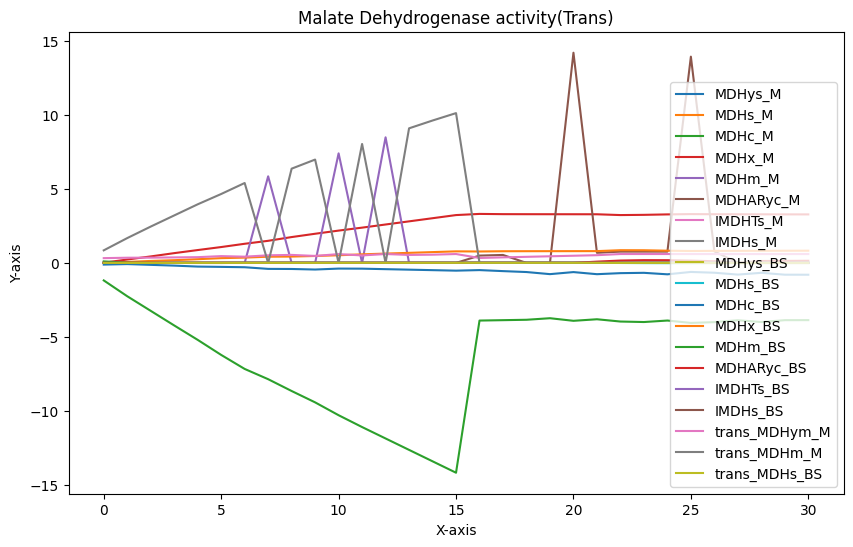

In [81]:
plot_rows_as_lines(MDH_trans_flux, 'Malate Dehydrogenase activity(Trans)')

In [80]:
wt_model.reactions.MDHARyc_M

Reaction identifier,MDHARyc_M
Name,"Monodehydroascorbate reductase (NADPH), cytosolic"
Memory address,0x7f71b5723ca0
Stoichiometry,3.0 h_c0 + 2.0 mhdascb_c0 + nadph_c0 --> 2.0 ascb-L_c0 + nadp_c0 3.0 H+ + 2.0 Monodehydroascorbate + Nicotinamide adenine dinucleotide phosphate - reduced --> 2.0 L-Ascorbate + Nicotinamide adenine dinucleotide phosphate
GPR,LOC_Os02g47790 or LOC_Os08g44340
Lower bound,0.0
Upper bound,1000000.0


In [28]:



PEP_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, ('PPCc', 'PPCs'))
PPD_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'PPDK')
RBPC_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'RBPC')
RBPO_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'RBPO')
HCO3_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'HCO3E')
MDH_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'MDH')
MDHy_trans_flux = subset_fluxes(MDH_trans_flux, 'MDHy')


MDHy_trans_flux

,25,75,125,175,225,275,325,375,425,475,...,1075,1125,1175,1225,1275,1325,1375,1425,1475,1525
MDHys_M,-0.000073,-0.000996,-0.001440,-0.002132,-0.004152,-0.003997,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MDHys_BS,0.000073,0.000996,0.001440,0.002132,0.004152,0.003997,0.001400,0.000000,0.000000,0.002068,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
trans_MDHym_M,0.322213,0.350289,0.355039,0.371452,0.387865,0.459178,0.420845,0.513622,0.540844,0.471225,...,0.521434,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6


Initial thoughts:
- Based on the Light scan experiments above we can see quite a greater variation in terms of Phloem output between flux ranges 200 to 500, and we can also see a minor increase in Rubisco activity in the BS cells. However, I think this still needs to be tested via flux sampling to determine the actual range.
- A similar dip exists even in the Wild type mature leaf but generally stabilizes faster compared to the transgenic rice. 
- I believe this is linked to ATP balancing and the transition from Mitochondrial ATP production to stromal ATP production.

- FUrthermore, I've observed that Rubisco activiity is also limited by Formate Dehydrogenase activity. When it is closed, Rubisco activity is only limited to around ~40 umol m2/s flux values (30 vc + 10 vo) while increasing the upper bound of FDHNc to around 25 allows it to have a ceiling of ~80 umol m2/s, which is around the experimental Rubisco activity measured by Ermakova et al (2021)
    - However, turning this reaction on causes the model to produce ATP with a flux rate that's almost x2 that of previous modelling attempts as checked from Shameer et al (2018, 2021). Furthermore, in Shameer et al (2021) the ranges for Rubisco carboxylation plays around 28-31, which is the maximum rate observed in this experiment. I think this would be a more viable route if ever.
    - Furthermore, based on Shameer et al's hybrid model and flux distributions the ATPase flux values are quite concordant with each other.
    - Lastly, the results pertaining to ATP synthesis is quite concordant with the results obtained by Shameer et al in their 2018 publication wherein mito-stromal ATP synthase shift was also observed.
    
    - Weirdly enough I'm observing that the addition of the trans constraints caused the flow of CO2 directly from the M cell to the BS cell at moderate light conditions, as opposed to the WT. Furthermore, more background flux is observed in all cases in the transgenic 2 cell. 
        - I need to check whether the absolute fluxes actually varied in these cases.
    
    - In both WT and Transgenic models Pyruvate is the predominant flux at low to medium light levels, while in the Transgenic model there is actual Gas flux from M to BS cells (both CO2 and O2)
    - In the transgenic model some flux of Glycolate from the M cell is detected in high light conditions (>750 ppfd) while some backflow of g3p from the BS cell to the M cell is observed.
    - PPFD to CO2 assimilation is much more steeper than what I've obtained in the past. I wonder why? I'm not too sure about it either
        - I think it is because I was only inputting NO3 into the mix rather than both NH3/NO3, as well as having free H+ import, which I closed. 
            - Upon testing this, I've observed that limiting H+ import now prevents that sharp increase in CO2 assimilation, with Max A approximately around 800 ppfd. Furthermore, an infeasible solution is now obtained for light intensities below 50 umol m2/s owing to the lack of source for proton demand. 
            - Adjusting this, an A roughly equivalent to the measured dark respiration values measured by Ermakova et al (2021)  is now obtained around 50 ppfd (Which, conversely, is the threshold designated by Topfer et al (2020) to delineate light compensation.
                - Maybe I can design an experiment to find the minimum value where the solver can find a feasible solution, then compare that to the trans one?
            -Adjusting the H+ demand (by allowing H+ import and varying import rates) actually removes the inverse relationship between Mitochondrial and Stromal ATP synthase flux. What gives?
                - I think modelling artifact yun since it allows system to simply import yung surplus H+ nila even though it could be supplied by photosynthesis (H2O  -> 2H2 + O2 based nga dun sa light reaction stoichiometry)
                (APRIL 13, 2023) What I've observed was that this was definitely a modelling artifact due to internal cycles that consume and produce excess H+  that generated more ATP than what was thermodynamically feasible. 
    

#Notes: Nov 26, 2022
I've revised the reaction for PEPC which I've changed from CO2 +H2O + PEP <-> Pi + H+ + OAA to HCO3 + PEP <-> Pi + OAA

In [ ]:
#Other artifacts as of the moment include the following:
#model doesn't produce any Oxygen. Maybe I should add a specific demand reaction for it?
#Based on FVA, the model now produces some oxygen via the demand reaction. 

In [ ]:
#Model also facilitates transfer of metabolites unlike before.

In [ ]:
#Questions:
#Should I restrict Nutrient flow to the Bundle Sheath Cell only or should I allow flux to both the M and BS cell?
#Apparently kasi dito only the Bundle sheath cells produce any biomass
#This is to ensure that only CO2 and Light flux are the only limiting constraints to the system.